# Real Data, Model 2
**Root notebook: [Microbial_Scaling_Laws](../Microbial_Scaling_Laws.ipynb)**

In [ ]:
import math
import numpy as np
from scipy import stats

from pynverse import inversefunc
import pandas as pd

import emcee
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

from Fernando_package import functions
from Fernando_package import plot_funcs
from Fernando_package.functions import prior_omega2

In [ ]:
df_microbial_growth = pd.read_csv('../data/modified_Susman18_physical_units.csv')
xb_realdata = df_microbial_growth['length_birth'][0]

# remove first NaN
df_microbial_growth  =  df_microbial_growth[~ np.isnan(df_microbial_growth['division_ratio'])]

# check that there is only one cell in the dataset
print('Number of cells in the dataset:', df_microbial_growth['lineage_ID'].nunique()) 

display(df_microbial_growth)
size = len(df_microbial_growth['generationtime'])

Number of cells in the dataset: 1


div_and_fold  fold_growth  division_ratio  added_length  generationtime  \
1        1.009831     0.794984        0.456028      3.198324        0.500000   
2        0.862482     0.607893        0.469619      2.291172        0.416667   
3        1.426486     1.037370        0.505526      4.632409        0.833333   
4        0.729601     0.490156        0.446903      2.028413        0.333333   
5        0.887982     0.609464        0.482744      2.121432        0.416667   
..            ...          ...             ...           ...             ...   
247      0.940427     0.590789        0.520893      2.192641        0.416667   
248      0.928602     0.604227        0.507478      2.069835        0.500000   
249      1.568073     1.046815        0.550478      4.644408        0.750000   
250      0.809727     0.481681        0.500204      2.215210        0.333333   
251      0.860970     0.711011        0.422863      2.538870        0.500000   

     length_birth  length_final  growth_rate  lineage_ID  generation  \
1        2.633655      5.831979     1.589968        15.0         1.0   
2        2.738808      5.029980     1.458944        15.0         2.0   
3        2.542786      7.175195     1.244844        15.0         3.0   
4        3.206619      5.235033     1.470468        15.0         4.0   
5        2.527183      4.648614     1.462714        15.0         5.0   
..            ...           ...          ...         ...         ...   
247      2.722385      4.915026     1.417893        15.0       249.0   
248      2.494268      4.564104     1.208453        15.0       250.0   
249      2.512440      7.156848     1.395754        15.0       251.0   
250      3.579885      5.795095     1.445043        15.0       252.0   
251      2.450531      4.989402     1.422022        15.0       253.0   

     start_time    end_time  
1      1.083333    1.583333  
2      1.666667    2.083333  
3      2.166667    3.000000  
4      3.083333    3.416667  
5      3.500000    3.916667  
..          ...         ...  
247  150.583333  151.000000  
248  151.083333  151.583333  
249  151.666667  152.416667  
250  152.500000  152.833333  
251  152.916667  153.416667  

[251 rows x 12 columns]

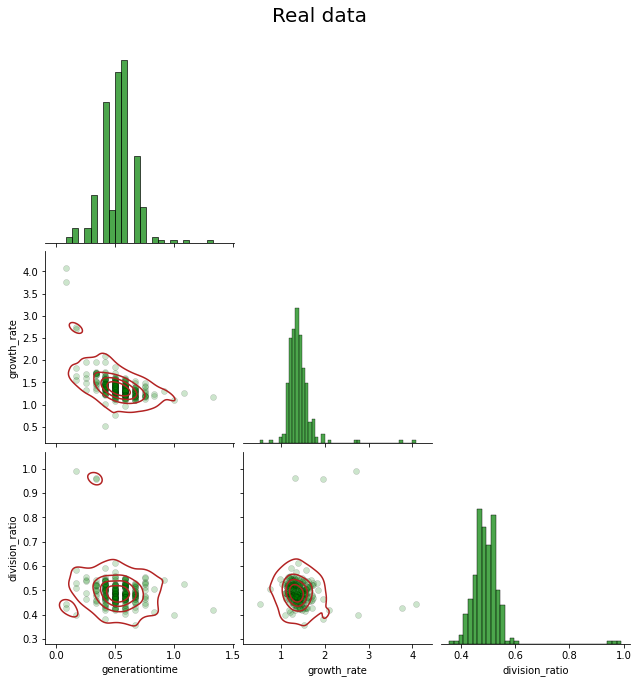

In [ ]:
g = sns.pairplot(
    df_microbial_growth[['generationtime', 'growth_rate', 'division_ratio']], diag_kind="hist", corner=True, 
    plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7}, height=3
)
g.map_lower(sns.kdeplot, levels=5, color="firebrick")
g.fig.suptitle('Real data', y=1.05, fontsize=20)
plt.show()

### Real data 3D plot of the triplet $f$, $\omega_1$ and $\tau$

In [ ]:
fig = plot_funcs.plot_3d_interactive(df_microbial_growth)
fig.show()

## Estimate the distribution of $\omega_1$ and frac $f$ from real data

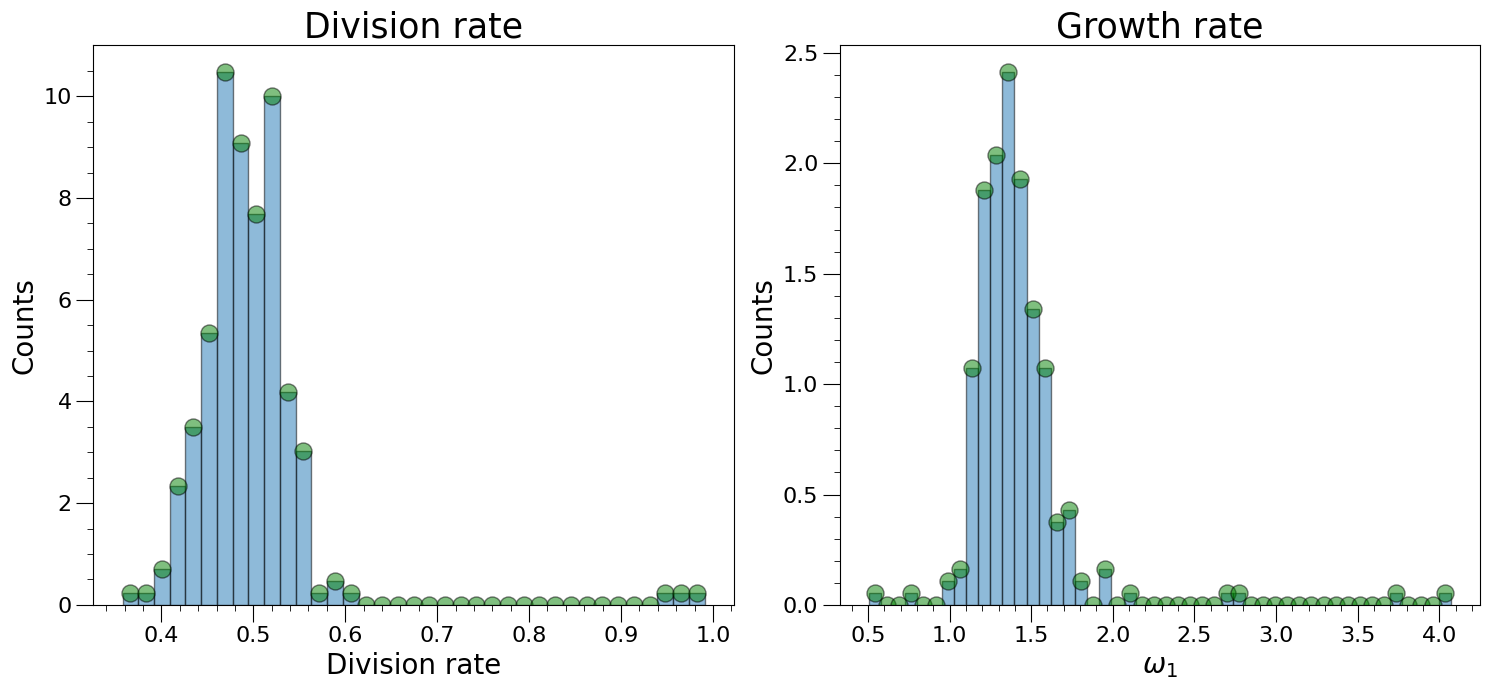

In [ ]:
fig, ax = plt.subplots(1,2 , figsize=(15, 7))

hist_val_div = ax[0].hist(df_microbial_growth['division_ratio'], bins='fd', edgecolor='black', alpha=0.5, density=True)
div_centers = (hist_val_div[1][:-1] + hist_val_div[1][1:]) / 2
ax[0].scatter(div_centers, hist_val_div[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[0].set_xlabel('Division rate', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_title('Division rate', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=16, size=12)
ax[0].xaxis.set_tick_params(which='minor', size=4)
ax[0].yaxis.set_tick_params(labelsize=16, size=12)
ax[0].yaxis.set_tick_params(which='minor', size=4)
ax[0].minorticks_on()

hist_val_grow = ax[1].hist(df_microbial_growth['growth_rate'], bins='fd', edgecolor='black', alpha=0.5, density=True)
grow_centers = (hist_val_grow[1][:-1] + hist_val_grow[1][1:]) / 2
ax[1].scatter(grow_centers, hist_val_grow[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[1].set_xlabel('$\\omega_1$', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].set_title('Growth rate', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=16, size=12)
ax[1].xaxis.set_tick_params(which='minor', size=4)
ax[1].yaxis.set_tick_params(labelsize=16, size=12)
ax[1].yaxis.set_tick_params(which='minor', size=4)
ax[1].minorticks_on()

fig.tight_layout()

In [ ]:
def fit_beta(x, a, b):
    return(scp.stats.beta.pdf(x, a=a,b=b))

def fit_gamma(x, a, teta):
    return(scp.stats.gamma.pdf(x, a=a, scale=teta))

popt_b, pcov_b = scp.optimize.curve_fit(fit_beta, xdata=div_centers, ydata = hist_val_div[0])
popt_g, pcov_g = scp.optimize.curve_fit(fit_gamma, xdata=grow_centers, ydata = hist_val_grow[0])

a_beta  = popt_b[0]; b_beta  = popt_b[1]
c_gamma = popt_g[0]; d_gamma = popt_g[1]

print('The parameters found for the beta distribution are:')
print('a =', np.round(a_beta,1),'+-', np.round(np.sqrt(pcov_b)[0,0],1))
print('b =', np.round(b_beta,1),'+-', np.round(np.sqrt(pcov_b)[1,1],1))

print('\nThe parameters found for the gamma distribution are:')
print('c =', np.round(c_gamma,1),'+-', np.round(np.sqrt(pcov_g[0,0]),1))
print('d =', np.round(d_gamma,3),'+-', np.round(np.sqrt(pcov_g[1,1]),3))


The parameters found for the beta distribution are:
a = 76.6 +- 6.0
b = 79.6 +- 6.2

The parameters found for the gamma distribution are:
c = 63.8 +- 2.6
d = 0.021 +- 0.001


## Priors

In [ ]:
def prior_mu_nu(mu, nu):
    if mu>=nu:
        return(-np.inf)
    else:
        return(np.log(stats.beta.pdf(mu, a=2, b=5))+np.log(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9))))

def prior_a(a):
    return(stats.norm.pdf(a, loc=a_beta, scale=10*np.sqrt(10*pcov_b[0,0])))    #a for frac beta pdf

def prior_b(b):
    return(stats.norm.pdf(b, loc=b_beta, scale=10*np.sqrt(pcov_b[1,1])))    #b for frac beta pdf

def prior_c(c):
    return(stats.norm.pdf(c, loc=c_gamma, scale=10*np.sqrt(pcov_g[0,0])))   #c for w1 gamma pdf

def prior_d(d):
    return(stats.norm.pdf(d, loc=d_gamma, scale=10*np.sqrt(pcov_g[1,1])))   #d for w1 gamma pdf

priors = {
    'mu_nu': prior_mu_nu,
    'omega2': prior_omega2,
    'a': prior_a, 
    'b': prior_b, 
    'c': prior_c, 
    'd': prior_d
}

## EMCEE

In [ ]:
n_walkers = 20

# initial state - p0

p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_mu = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)

p0_a = np.random.uniform(low=a_beta, high=a_beta+np.sqrt(pcov_b[0,0]), size=n_walkers).reshape(-1,1)
p0_b = np.random.uniform(low=b_beta , high=b_beta+np.sqrt(pcov_b[1,1]), size=n_walkers).reshape(-1,1)
p0_c = np.random.uniform(low=c_gamma , high=c_gamma+np.sqrt(pcov_g[0,0]), size=n_walkers).reshape(-1,1)
p0_d = np.random.uniform(low=d_gamma , high=d_gamma+np.sqrt(pcov_g[1,1]), size=n_walkers).reshape(-1,1)

p0 = np.hstack([p0_omega_2, p0_mu, p0_nu, p0_a, p0_b, p0_c, p0_d])

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# emcee, using real data
sampler = emcee.EnsembleSampler(n_walkers, 7, functions.j_log_unnorm_posterior_emcee_2, 
                                kwargs={'y_times':np.array(df_microbial_growth['generationtime']), 
                                        'frac': np.array(df_microbial_growth['division_ratio']),
                                        'omega_1': np.array(df_microbial_growth['growth_rate']),
                                        'PDF': functions.PDF,
                                        'h_func' : functions.h_mod2,
                                        'cdf_func' : functions.CDF_mod2,
                                        'xb': np.array(df_microbial_growth['length_birth']),
                                        'priors': priors
                                        },
                                        a=2
                                )
burn_in = 1700
n_steps = 5000

# burn-in 
pos, prob, state = sampler.run_mcmc(p0, burn_in)
sampler.reset()

# run mcmc
sampler.run_mcmc(pos, n_steps, rstate0=state)

# get chains
chain_mod2_sim = sampler.get_chain(flat=True)


## Results

Median value of  $\omega_2$ : 1.2167
Max value of  $\omega_2$  : 1.2268
Credibility interval of  $\omega_2$  : [ 0.81 , 1.5331 ]


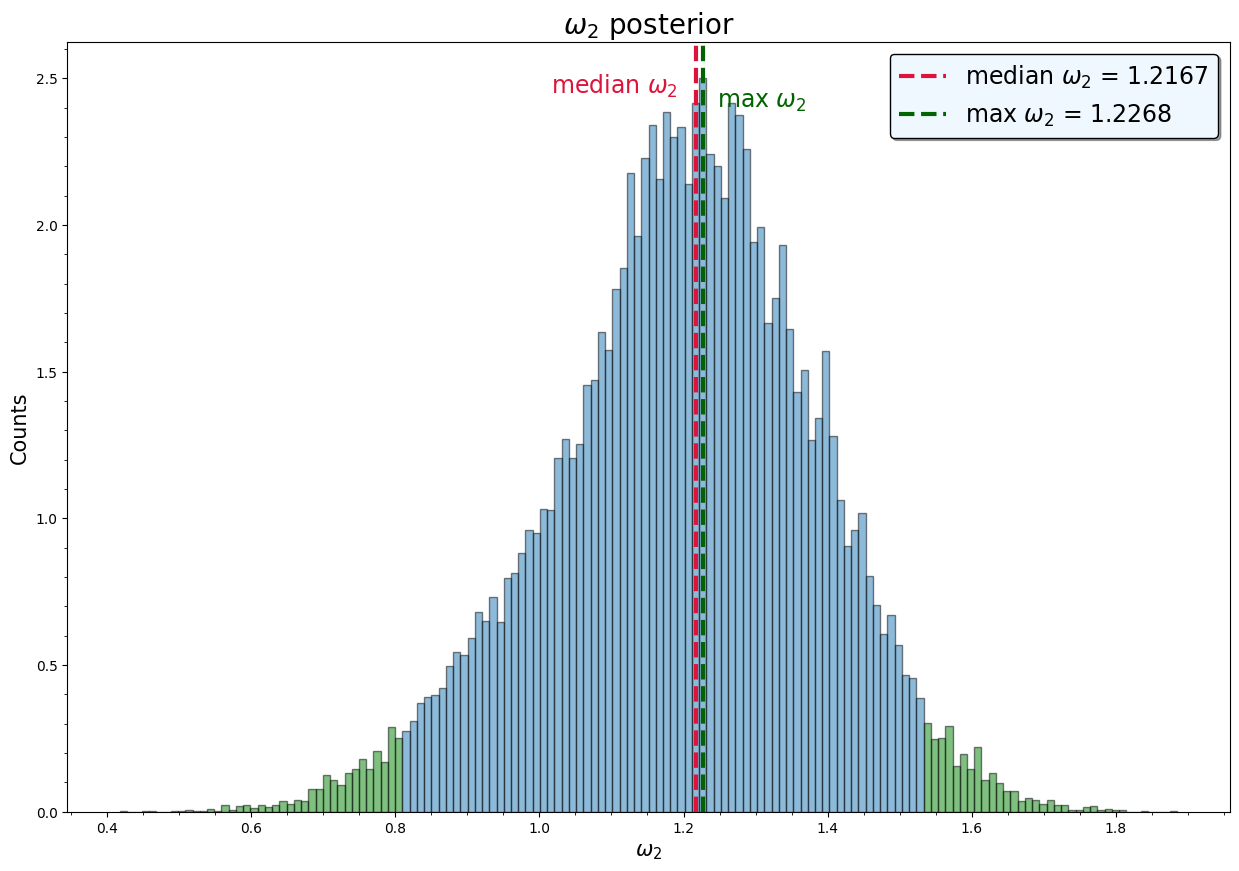

In [ ]:
fig, ax, centers_omega2_mod2_r, counts_omega2_mod2_r, max_omega2, ci_low_omega2, ci_high_omega2 = plot_funcs.plot_func_sim(
    chain = chain_mod2_sim, parameter = 'omega_2', y_max=2.4, y_median=2.45, x_median=-0.2, info=False
)

Median value of  $\mu$ : 0.4636
Max value of  $\mu$  : 0.5455
Credibility interval of  $\mu$  : [ 0.1879 , 0.5482 ]


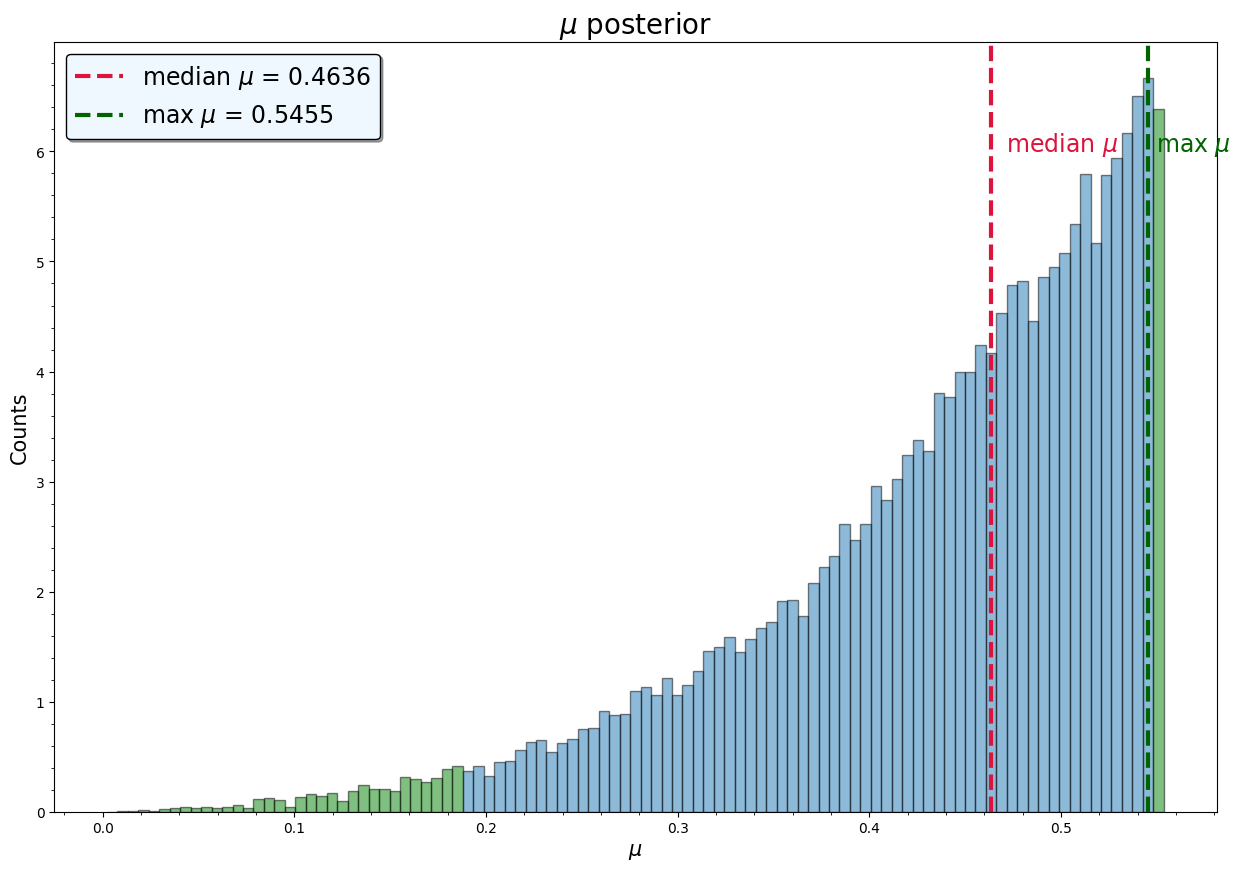

In [ ]:
fig, ax, centers_mu_mod2_r, counts_mu_mod2_r, max_mu, ci_low_mu, ci_high_mu = plot_funcs.plot_func_sim(
    chain = chain_mod2_sim, parameter = 'mu', x_median= 0.008, x_max=0.004, y_max=6, y_median=6, info=False
)

Median value of  $\nu$ : 0.6392
Max value of  $\nu$  : 0.5787
Credibility interval of  $\nu$  : [ 0.4387 , 0.9984 ]


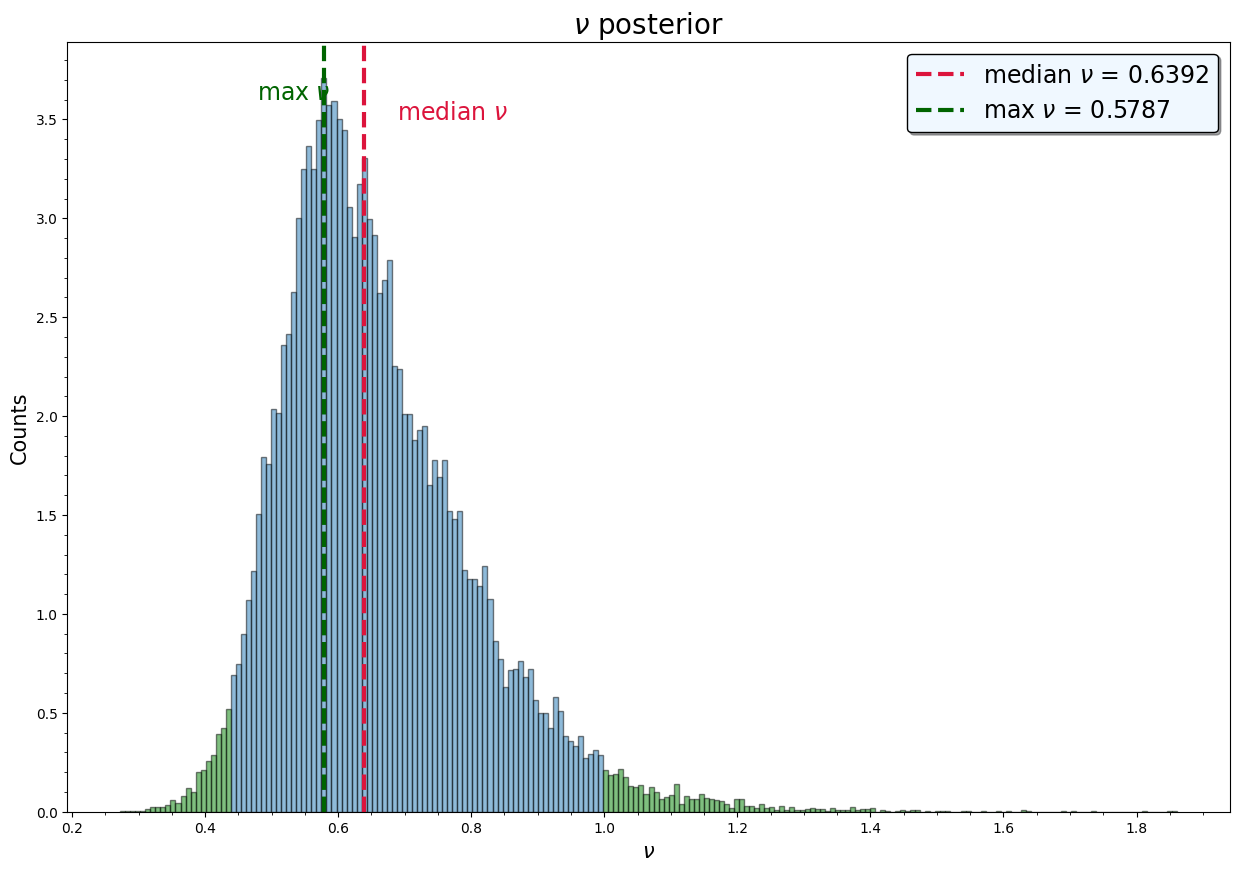

In [ ]:
fig, ax, centers_nu_s_r, counts_nu_s_r, max_nu, ci_low_nu, ci_high_nu = plot_funcs.plot_func_sim(
    chain= chain_mod2_sim, parameter='nu', y_max=3.6, y_median=3.5, x_median=+0.05, x_max=-0.1, info=False
)

Median value of  a : 14.9921
Max value of  a  : 14.8366
Credibility interval of  a  : [ 12.5431 , 17.6744 ]


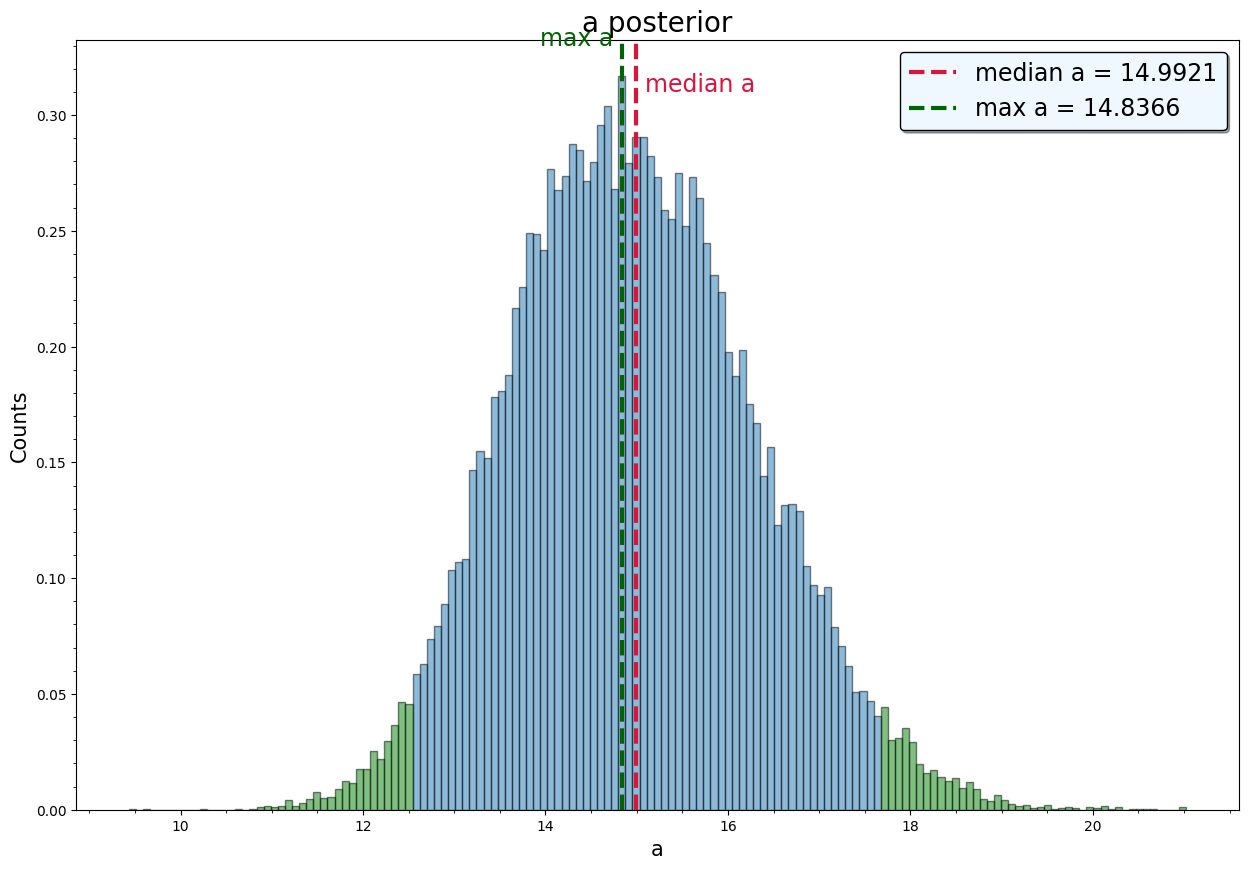

In [ ]:
fig, ax, centers_a_s_r, counts_a_s_r, max_a, ci_low_a, ci_high_a = plot_funcs.plot_func_sim(
    chain= chain_mod2_sim, parameter='a' , y_max=0.33 , y_median= 0.31, x_median=0.1, x_max=-0.9, info=False
)

Median value of  b : 14.9698
Max value of  b  : 14.3487
Credibility interval of  b  : [ 12.524 , 17.6486 ]


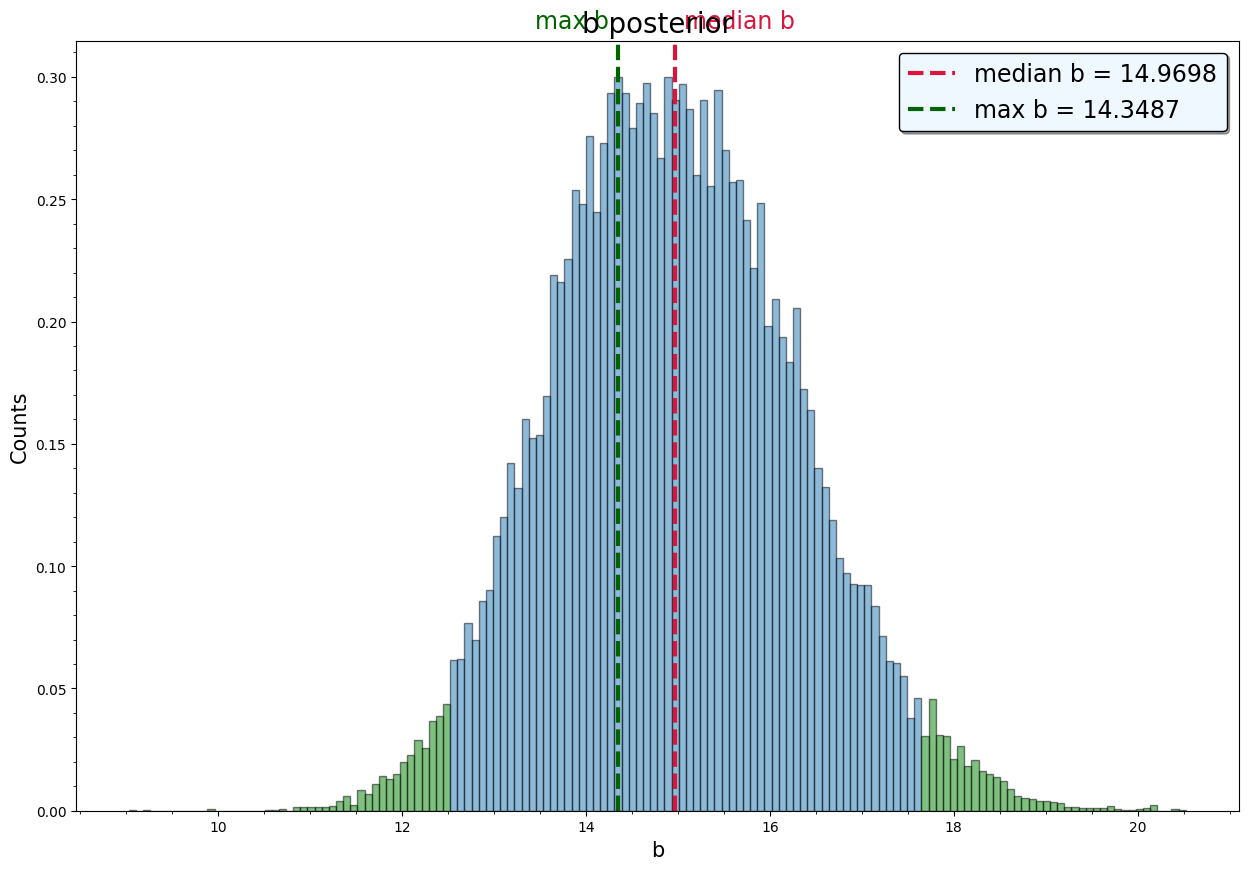

In [ ]:
fig, ax, centers_b_s_r, counts_b_s_r, max_b, ci_low_b, ci_high_b = plot_funcs.plot_func_sim(
    chain= chain_mod2_sim, parameter='b', y_max=0.32, y_median=0.32, x_max=-0.9, x_median=0.1, info=False
)

Median value of  c : 30.7245
Max value of  c  : 30.4743
Credibility interval of  c  : [ 26.41 , 35.0389 ]


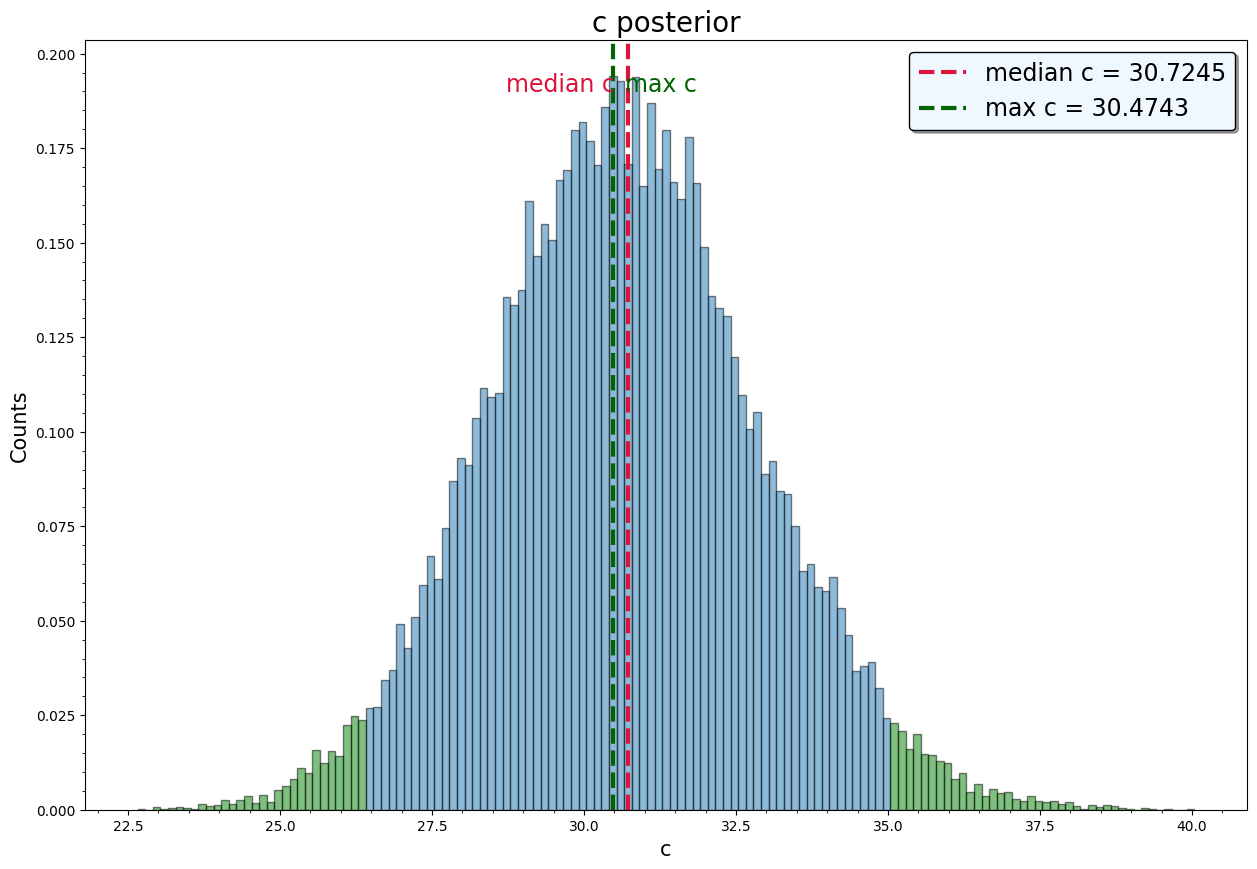

In [ ]:
fig, ax, centers_c_s_r, counts_c_s_r, max_c, ci_low_c, ci_high_c = plot_funcs.plot_func_sim(
    chain= chain_mod2_sim,  parameter='c', y_max=0.19, y_median=0.19, x_max=0.2, x_median=-2, info=False
)

Median value of  d : 0.046
Max value of  d  : 0.0458
Credibility interval of  d  : [ 0.0398 , 0.053 ]


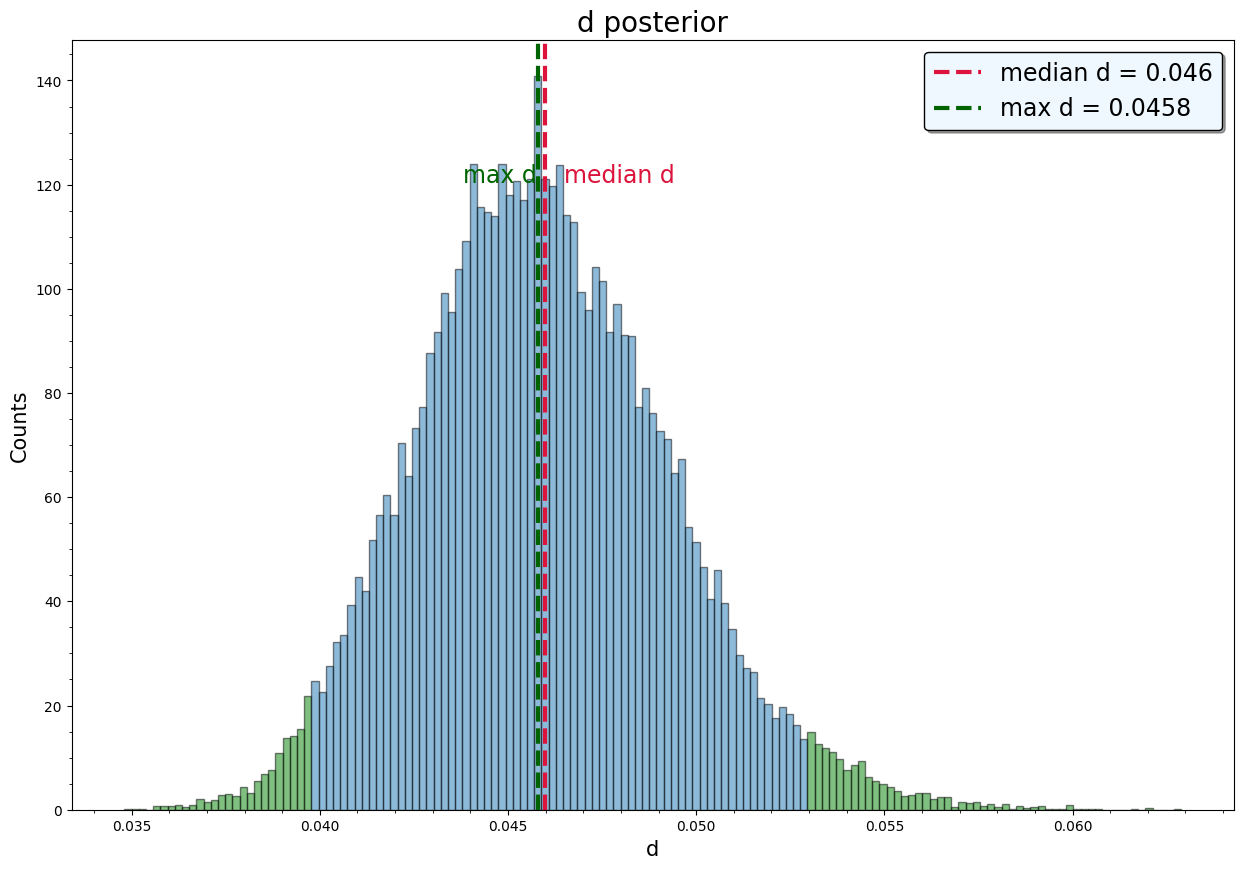

In [ ]:
fig, ax,centers_d_s_r, counts_d_s_r, max_d, ci_low_d, ci_high_d = plot_funcs.plot_func_sim(
    chain= chain_mod2_sim, parameter='d', x_max=-0.002, x_median=0.0005, y_max=120.5, y_median=120.5, info=False
)

In [ ]:
# create file with the results of the inference
filepath = '../data/model2.csv'
create_file = True

if create_file:
    df_mod2 = pd.DataFrame({'omega_2': [max_omega2, ci_low_omega2, ci_high_omega2],
                       'mu':[max_mu, ci_low_mu, ci_high_mu],
                       'nu':[max_nu, ci_low_nu, ci_high_nu],
                       'a':[max_a, ci_low_a, ci_high_a],
                       'b':[max_b, ci_low_b, ci_high_b],
                       'c':[max_c, ci_low_c, ci_high_c],
                       'd':[max_d, ci_low_d, ci_high_d]})
    df_mod2.to_csv(filepath, index=False)

df_mod2 = df_mod2.round(4).rename({0: 'PosteriorMax',
                          1: 'LowerBoundCI',
                          2: 'UpperBoundCI'})

display(df_mod2)

omega_2      mu      nu        a        b        c       d
PosteriorMax   1.2268  0.5455  0.5787  14.8366  14.3487  30.4743  0.0458
LowerBoundCI   0.8100  0.1879  0.4387  12.5431  12.5240  26.4100  0.0398
UpperBoundCI   1.5331  0.5482  0.9984  17.6744  17.6486  35.0389  0.0530

## Chains


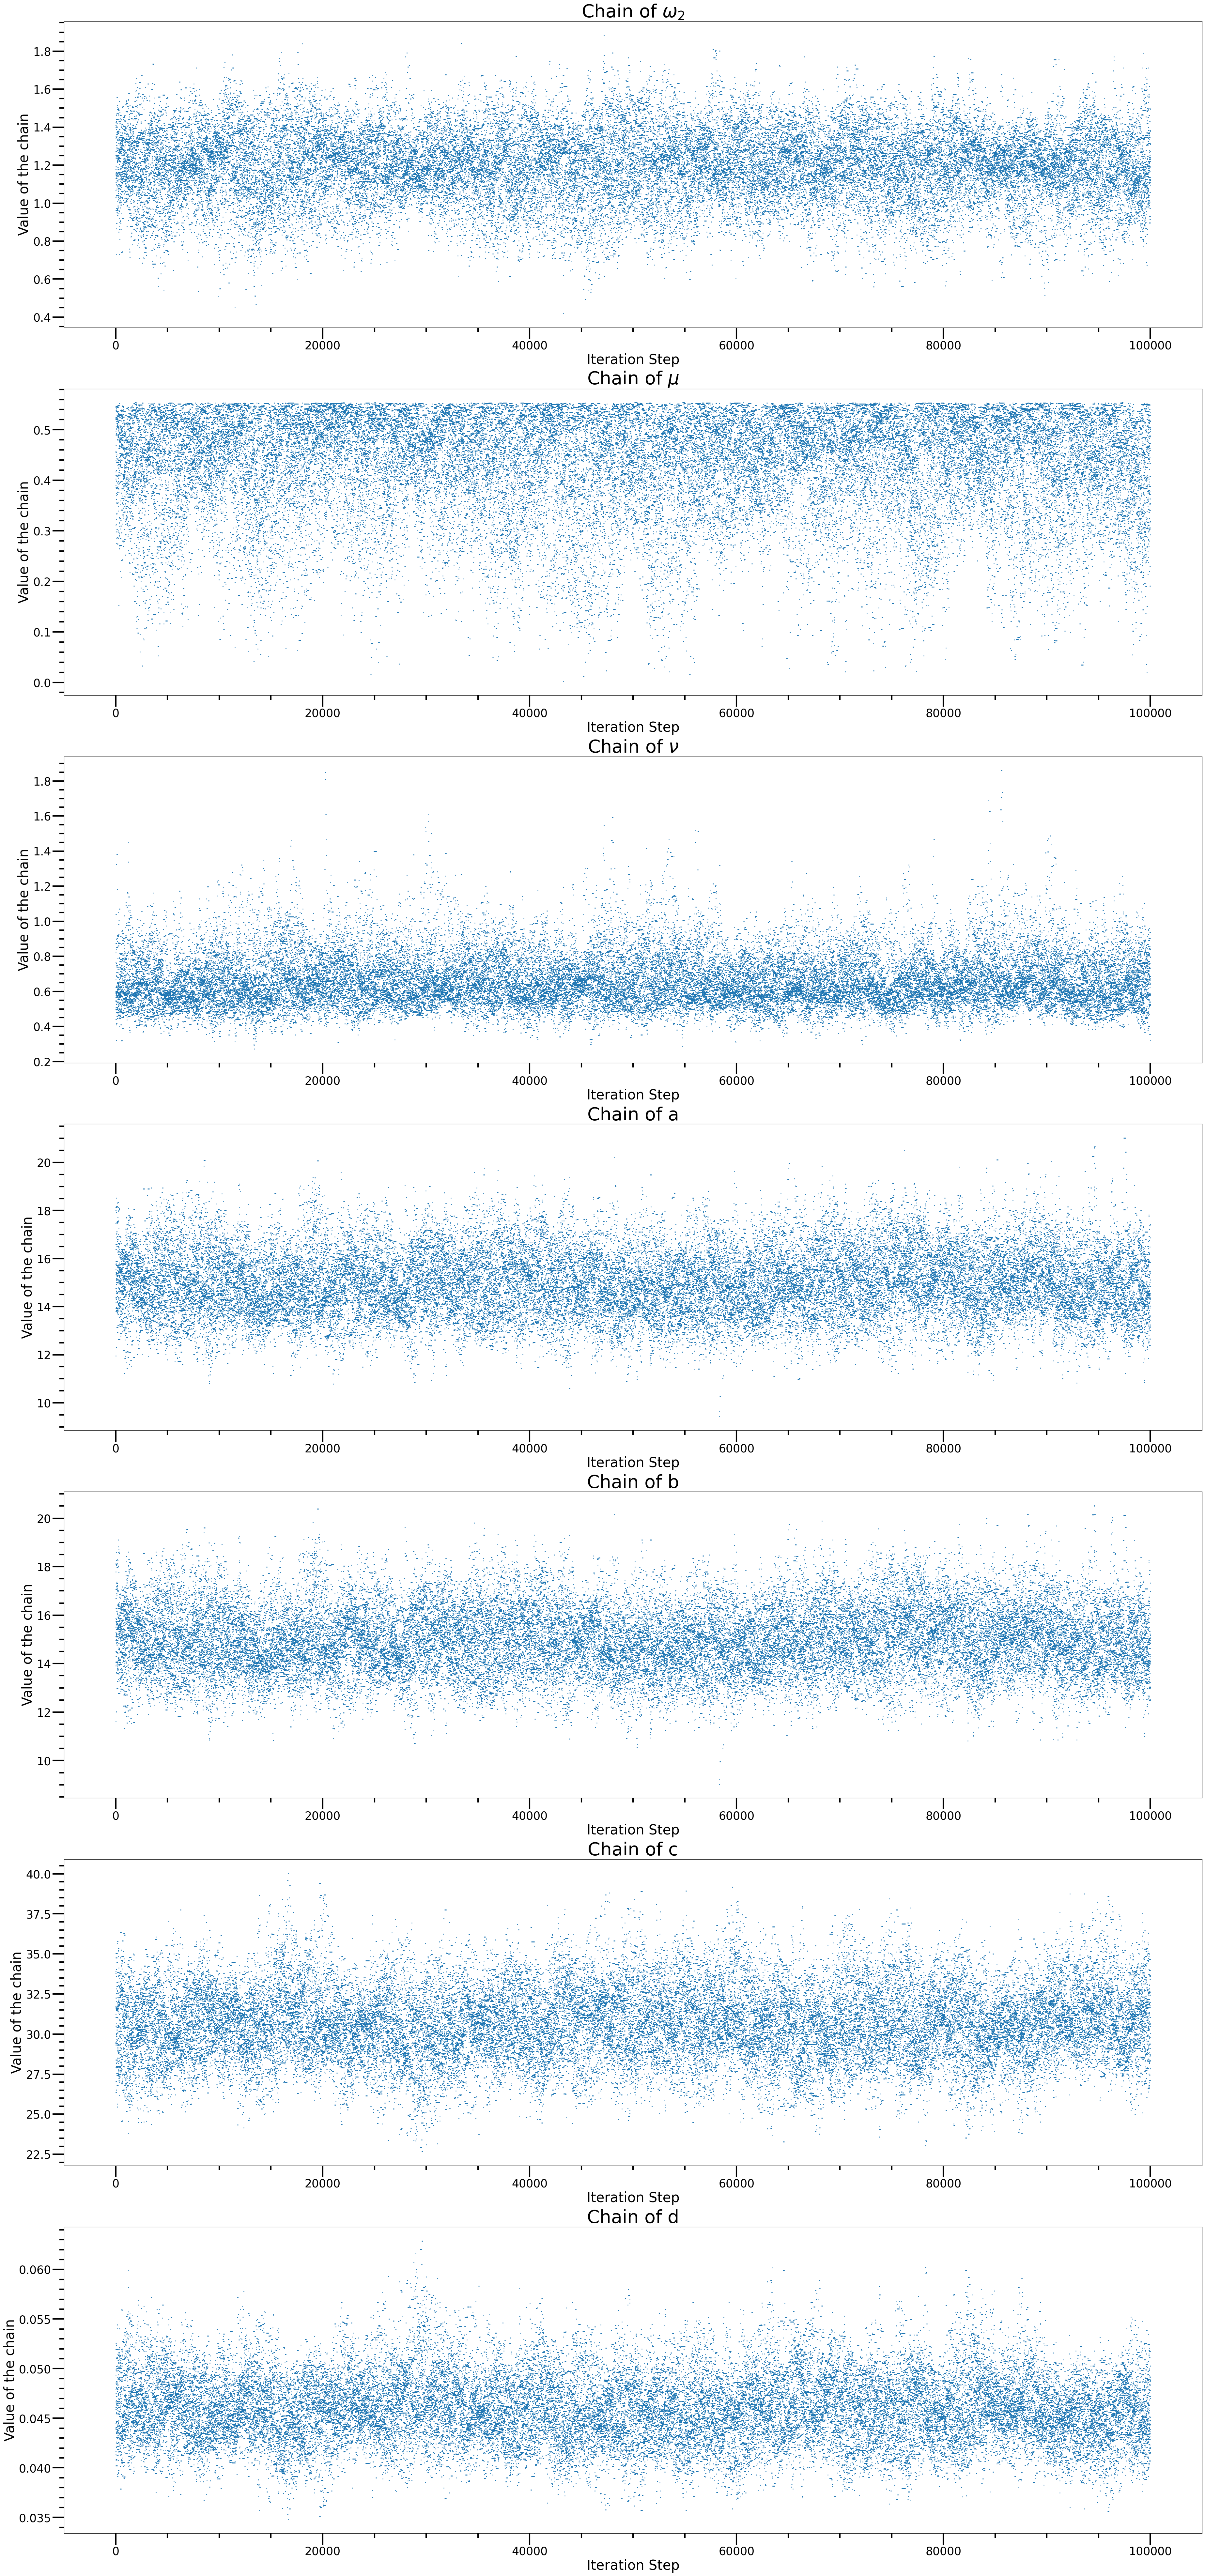

In [ ]:
plot_funcs.chains_plot(chain_mod2_sim, info=False)
fig.tight_layout(pad=15.0)

## Simulation of the time series

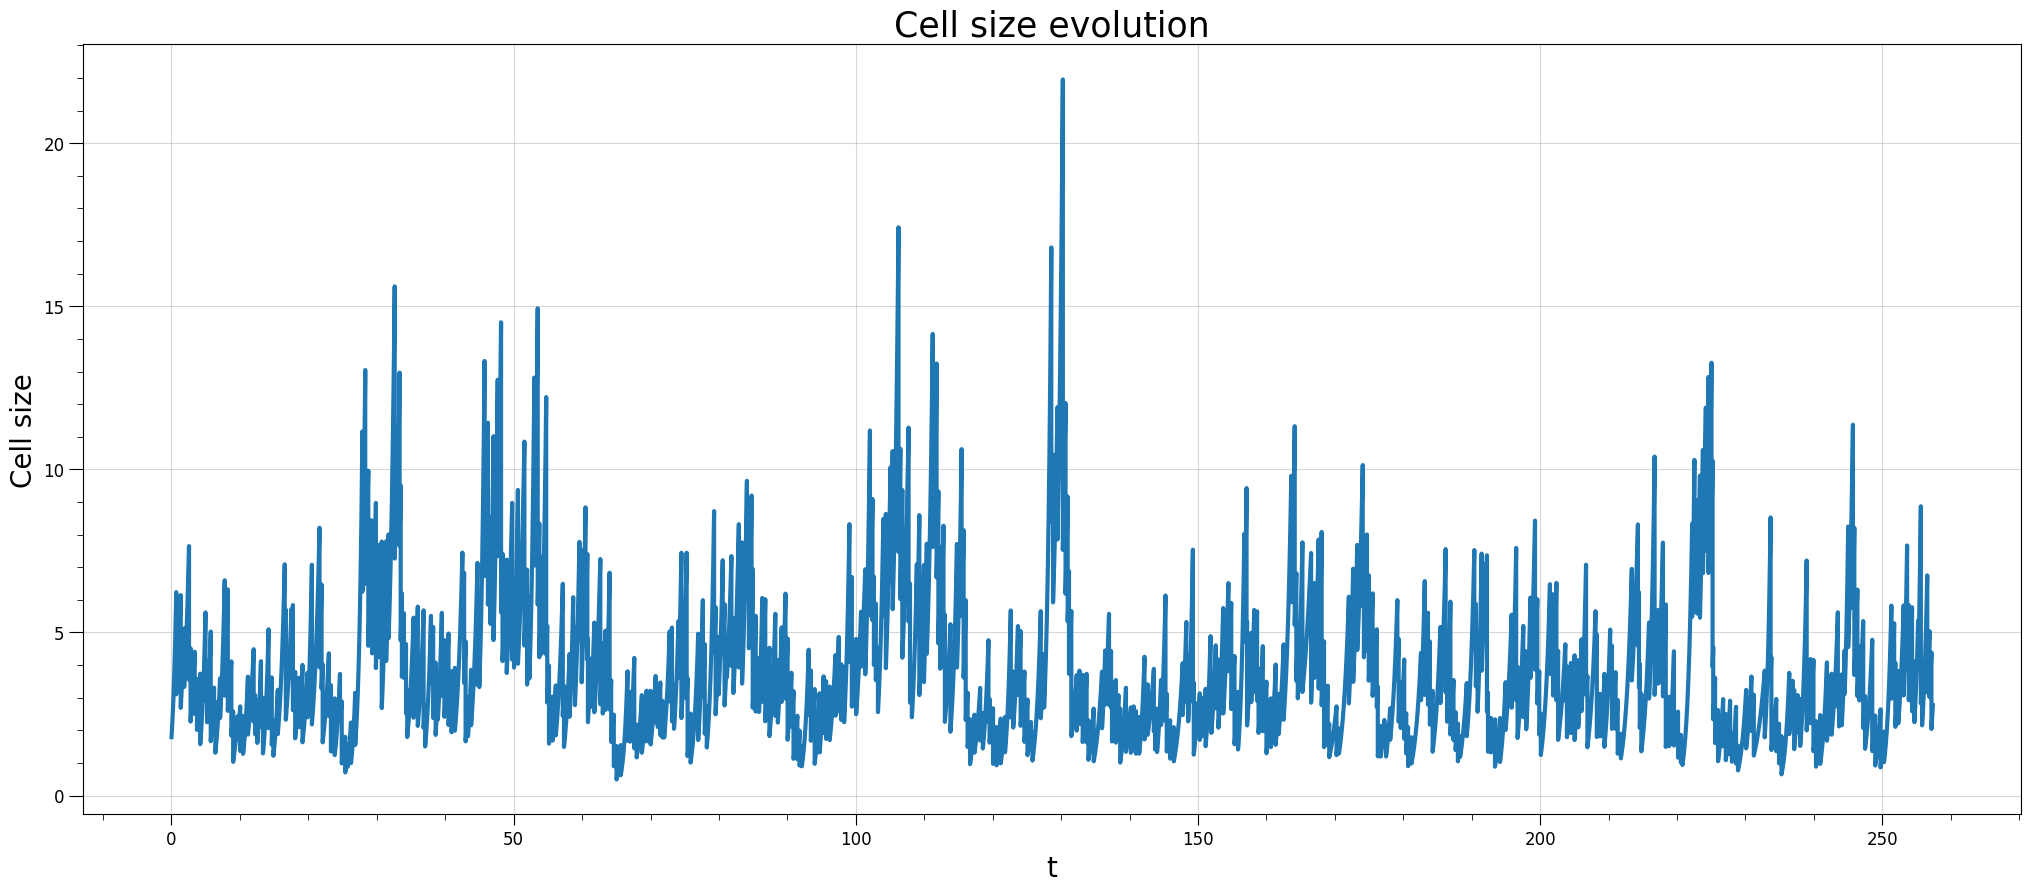

In [ ]:
sim_t_mod2, all_times_mod2, cell_sizes_mod2, frac_mod2, omg1_mod2 = functions.sim_t_draw(
    log_CDF=functions.log_CDF_mod2,
    x_function = functions.m_function,
    size = 500,
    points_per_evolution = 100,
    xb = xb_realdata,
    model = '2',
    pars_new = (max_omega2, max_mu, max_nu, max_a, max_b, max_c, max_d)
)

fig, ax = plot_funcs.plot_evol(all_times = all_times_mod2, cell_sizes = cell_sizes_mod2)
ax.set_ylabel('Cell size', fontsize=20)
ax.xaxis.set_tick_params(labelsize=12, size=8)
ax.xaxis.set_tick_params(which='minor', size=4)
ax.yaxis.set_tick_params(labelsize=12, size=10)
ax.yaxis.set_tick_params(which='minor', size=4)

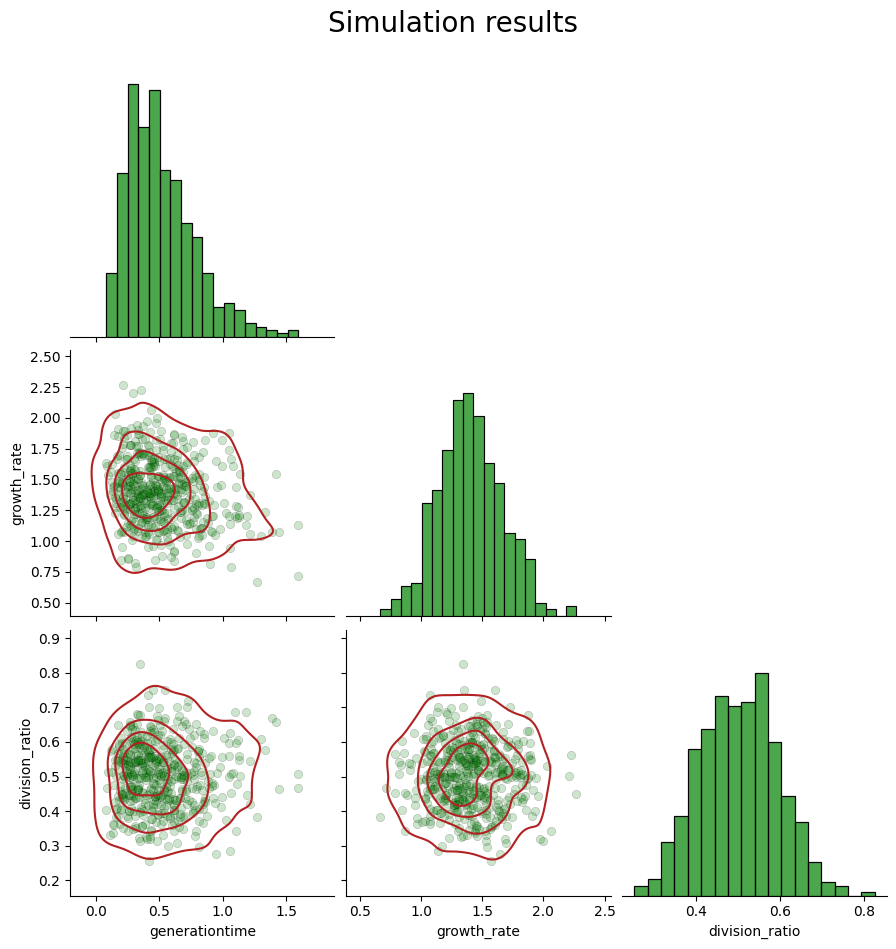

In [ ]:
df_sim_mod2 = pd.DataFrame()
df_sim_mod2['generationtime'] = sim_t_mod2
df_sim_mod2['growth_rate'] = omg1_mod2
df_sim_mod2['division_ratio'] = frac_mod2


g = sns.pairplot(
    df_sim_mod2, diag_kind="hist", corner=True, 
    plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7}, height=3
)
g.map_lower(sns.kdeplot, levels=5, color="firebrick")

plt.savefig('../images/pairplot_model2.png')

g.fig.suptitle('Simulation results', y=1.05, fontsize=20)
plt.show()


In [ ]:
fig = plot_funcs.plot_3d_interactive(df_sim_mod2, real_data_title=False)
fig.show()

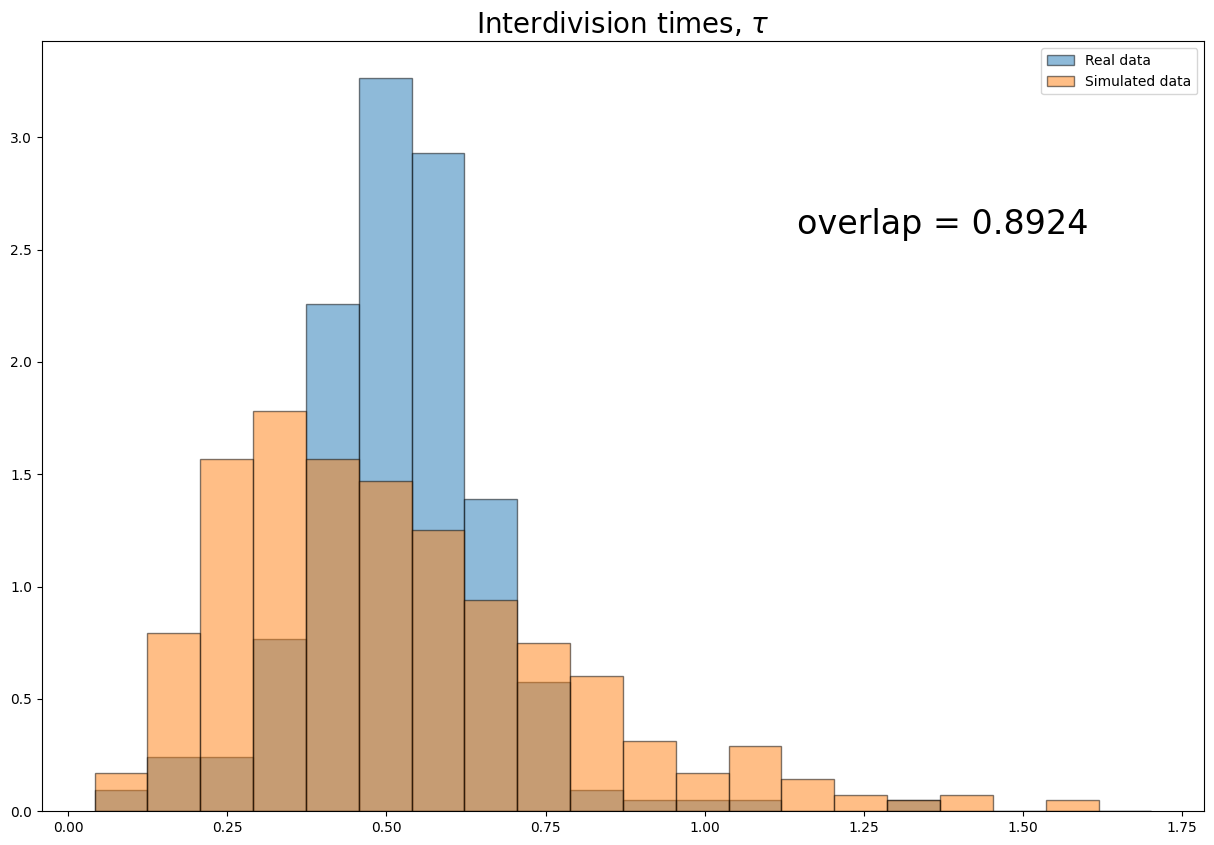

In [ ]:
# overlap metrics between histograms
fig,ax = plot_funcs.overlap_hist(real_data=df_microbial_growth['generationtime'], sim_data=df_sim_mod2['generationtime'])

plt.savefig('../images/overlap_model2.png')
plt.show()

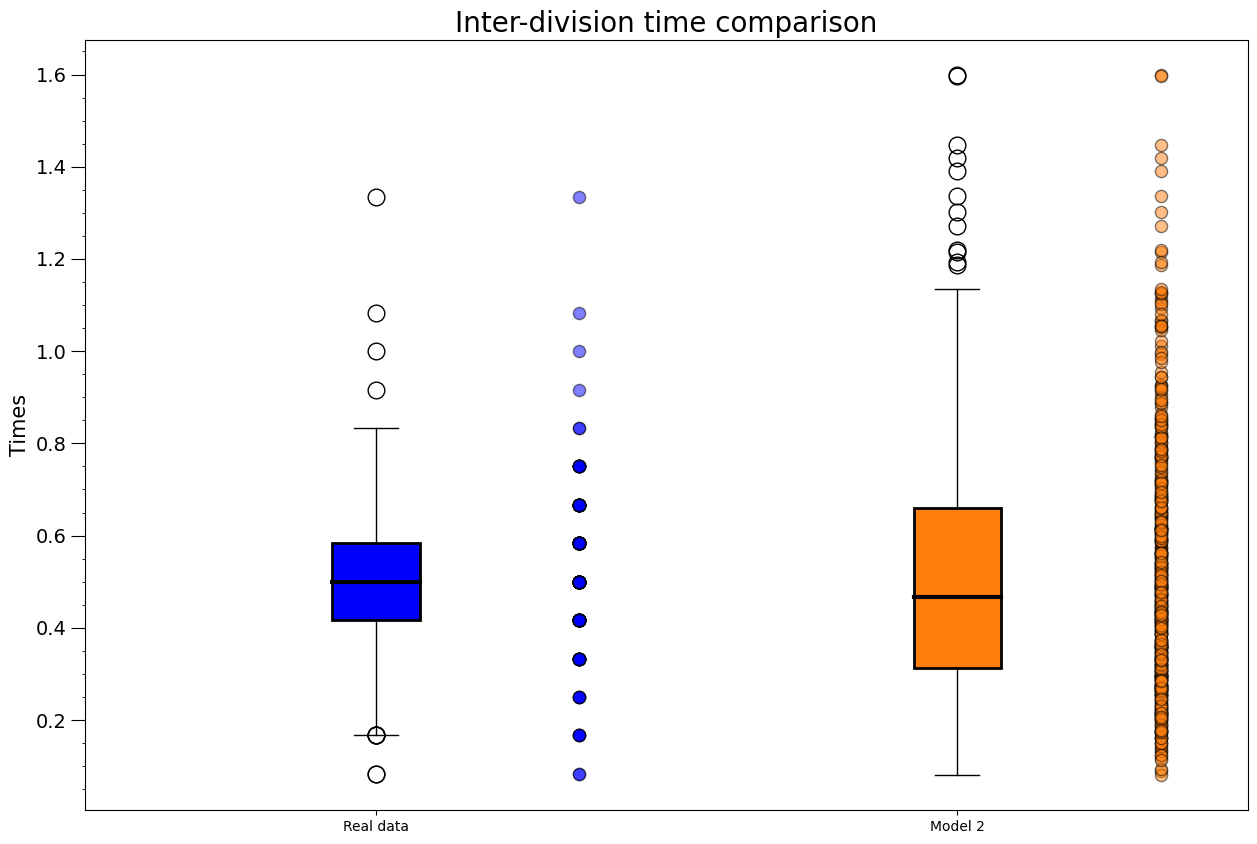

In [ ]:
plot_funcs.boxplot(y=[df_microbial_growth['generationtime'], sim_t_mod2], colors=['blue', 'C1'],  title = 'Inter-division time comparison', ylabel= 'Times', xlabel='', x_font= 30, labels=True, list_labels=['Real data', 'Model 2'] )
plt.show()


## Save the interdivision times in an external file

In [ ]:
filepath = '../data/timeseries.csv'

df = pd.read_csv(filepath)
df['model_2'] = df_sim_mod2['generationtime']
df.to_csv(filepath, index=False)

## Predictive density for model 2

In [ ]:
N_perm = 10
np.random.seed(24082003)
size_train = int(0.5*size)
log_predD = []

#### Priors

In [ ]:
priors = {
    'mu_nu': prior_mu_nu,
    'omega2': prior_omega2,
    'a': prior_a, 
    'b': prior_b, 
    'c': prior_c, 
    'd': prior_d
}

#### EMCEE initializations

In [ ]:
n_walkers = 20

# initial state
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_mu = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_a = np.random.uniform(low=a_beta, high=a_beta+np.sqrt(pcov_b[0,0]), size=n_walkers).reshape(-1,1)
p0_b = np.random.uniform(low=b_beta , high=b_beta+np.sqrt(pcov_b[1,1]), size=n_walkers).reshape(-1,1)
p0_c = np.random.uniform(low=c_gamma , high=c_gamma+np.sqrt(pcov_g[0,0]), size=n_walkers).reshape(-1,1)
p0_d = np.random.uniform(low=d_gamma , high=d_gamma+np.sqrt(pcov_g[1,1]), size=n_walkers).reshape(-1,1)

p0 = np.hstack([p0_omega_2, p0_mu, p0_nu, p0_a, p0_b, p0_c, p0_d])

### Cross validation procedure

In [ ]:
log_predD = functions.predictive_density(
    df_microbial_growth,
    size, 
    p0, 
    functions.h_mod2, 
    functions.CDF_mod2, 
    priors
)

In [ ]:
print("Logarithm of Predictive Density: ", log_predD[~np.isinf(log_predD)].mean(), " ± ", log_predD[~np.isinf(log_predD)].std())

Logarithm of Predictive Density:  42.80106188856764  ±  145.79308189915952


## Save the predictive densities times in an external file

In [ ]:
# create file with the mean predictive density and
# add the predictive densities with the starting model

filepath = '../data/pred_density.csv'
create_file = False

if create_file:
    df = pd.DataFrame({'starting_model': [],
                       'model_1':[],
                       'model_2':[]})
    df.to_csv(filepath, index=False)

# now a file exists
df = pd.read_csv(filepath)
df['model_2'] = log_predD
df.to_csv(filepath, index=False)

In [ ]:
filepath_scatter = '../data/scatter3d_model2.csv'
df_sim_mod2.to_csv(filepath_scatter, index=False)

For a comparison of the models we can go back to the **Root notebook: [Microbial_Scaling_Laws](../Microbial_Scaling_Laws.ipynb)**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>